In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [49]:
ma_list = [3,5,10,20,30]
stock_symbol = 'AAPL'

df = yf.Ticker(stock_symbol).history(period='max')
df = df.iloc[:,:-2]

df['Premarket_Change'] = df.Open - df.Close.shift(1)

# Get the Moving Average data
for col in ['Close','Volume']:
    for ma in ma_list:
        df[f'{col}_{ma}MA'] = df[col].rolling(ma).mean().shift(1)

df.dropna(inplace=True)

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(df.values)

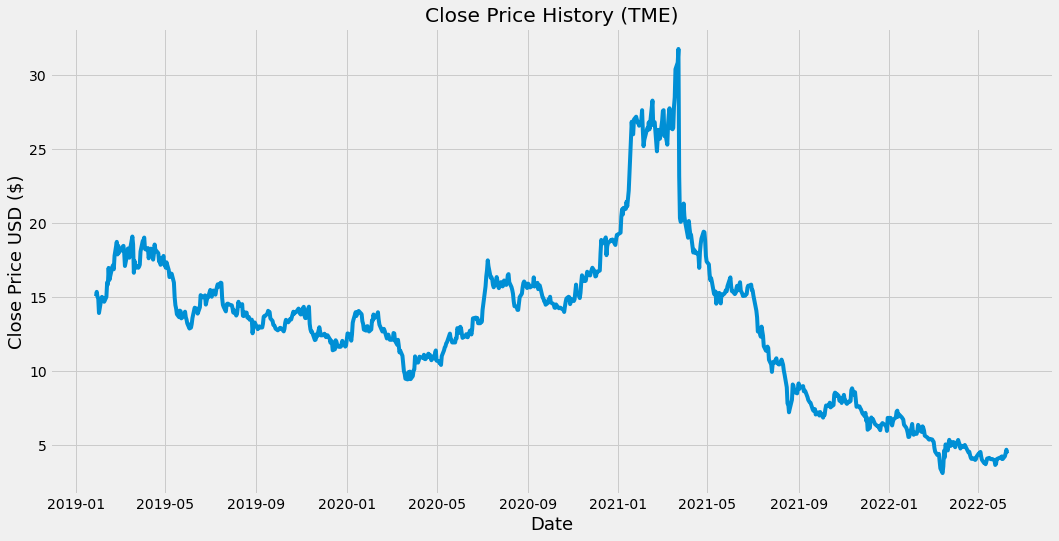

In [50]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title(f'Close Price History ({stock_symbol})')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [51]:
# Construct train and test data set
num_timestamp = 30
train_length = math.ceil(len(df) * 0.8)

# Creating training data set
train = scaled_df[:train_length,:]
x_train = []
y_train = []

for i in range(num_timestamp, train_length):
    x_train.append(train[i-num_timestamp:i,:])
    y_train.append(train[i,3])

x_train, y_train = np.array(x_train), np.array(y_train)

# Creating testing data set
test = scaled_df[train_length - num_timestamp: ,:]
x_test = []
y_test = df['Close'][train_length:].values

for i in range(num_timestamp, len(test)):
    x_test.append(test[i-num_timestamp:i,:])

x_test = np.array(x_test)

# LSTM expect the input to be 3D in the form of (# of samples, timestamp, # of features)
print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_test: {x_test.shape}')

Shape of x_train: (650, 30, 16)
Shape of x_test: (170, 30, 16)


In [52]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(num_timestamp,x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5)
model.save(f'model/LSTMStockModel({stock_symbol}).h5')

Epoch 1/5
650/650 [==============================] - 4s 5ms/step - loss: 0.0056
Epoch 2/5
650/650 [==============================] - 4s 5ms/step - loss: 0.0024
Epoch 3/5
650/650 [==============================] - 4s 5ms/step - loss: 0.0019
Epoch 4/5
650/650 [==============================] - 4s 6ms/step - loss: 0.0019
Epoch 5/5
650/650 [==============================] - 4s 6ms/step - loss: 0.0020


In [53]:
model = load_model(f'model/LSTMStockModel({stock_symbol}).h5')

In [54]:
# Get the model predicted price values
predictions = model.predict(x_test)
# Create a matrix for fitting in the scaler
temp_matrix = np.zeros((predictions.shape[0],16))
temp_matrix[:,3] = np.reshape(predictions, (predictions.shape[0],))
predictions = temp_matrix
# Unscaling the value
predictions = scaler.inverse_transform(predictions)
predictions = predictions[:,3]

In [55]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.46404471610493314

<ipython-input-56-8587a21adcf4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


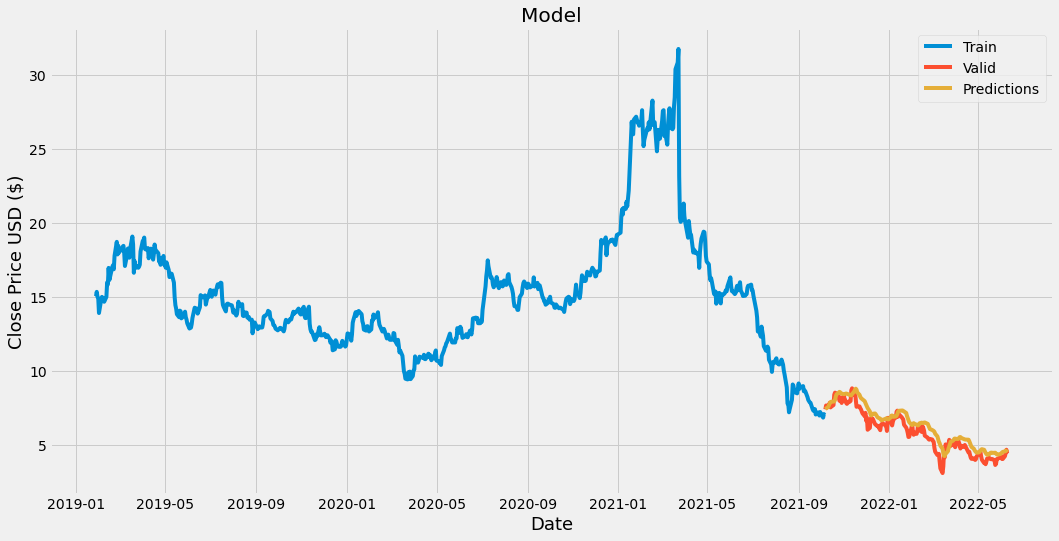

In [56]:
# Plot the data
train = df[:train_length]
valid = df[train_length:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='upper right')
plt.show()